# Scraping data from kilid.com

In [ ]:
import string
import re
import requests
from bs4 import BeautifulSoup
import mysql.connector
import numpy as np

data=[]     #this will save location, size, number of parkings and number of rooms
prices=[]   #this will save prices of houses


for p in range(501):
    url= 'https://kilid.com/buy/tehran?page=%i' %p

    resp= requests.get(url)
    if str(resp)== '<Response [404]>':
        continue
    else:
        result= resp.text

        dom= BeautifulSoup(result, 'html.parser')
        
        
        """getting price of houses"""
        pric= dom.select('.text-primary-700')
        #print(type(pric))
        #print(len(pric))
        price= []
        for i in range(1, 24):
            if i== 7:
                pass
            elif i==8:
                pass
            elif i==9:
                pass
            else:
                price.append(pric[i].text)
        #print(len(price))        
        #price

        #print('.......................................................')
        #prices= []
        for i in range(len(price)):
            a= re.findall('\d+', price[i])
            if len(a) >1:
                a= float(a[0]+ '.'+ a[1])
            elif len(a)== 0:
                a= np.nan
            else:
                a= float(a[0])
            prices.append(a)


        """getting locations"""
        place= dom.select(".inline-flex.text-grey-500")
        #print(type(place))
        #print(len(place))
        #print(place[1].text)
        
        
        """getting size, num of parking and num of rooms"""
        attribute= dom.select(".inline-flex.flex-wrap.-m-2")
        #print(type(att))
        #print('....................................')
        l= []
        for i in range(len(attribute)):
            #print(attribute[i].text)
            l.append(re.findall('\d+', attribute[i].text))
        #print(l)
        #print('..................................')


        d= dom.select(".style_plp-card-link__yPlrt")
        #len(d) ==== 20 

        for i in range(len(d)):

            x1= str(d[i]) 
            #print(type(x1))
            #print(x1)
            x= x1.partition('href=')[2] #should be 2
            r= x.split('>')
            #print(r[0])


        def get_data(attribute):

            #data= [place, size, parking, rooms]
            data= [None, None, None, None]

            data[0]= place[i].text

            l1= re.findall('\d+', attribute.text)
            data[1]= int(l1[0])

            if 'پارکینگ' in attribute.text:
                #print('1 is')
                data[2]= int(l1[1])
            else:
                data[2]= 0

            if 'خواب' in attribute.text:
                #print('2 is')
                data[3]= int(l1[-1])
            else:
                data[3]= 0
            return data

        #data= []
        for i in range(len(attribute)):
            data.append(get_data(attribute[i]))

    
    #if p % 5==0:
        #print('Page %i is done.' %p)
        #print('len data: ', len(data))
        #print('len prices: ', len(prices)) 
        #print(data)
        #print('...................................................')

# Making a data frame from scraped data

In [144]:
import pandas as pd
import numpy as np

data= pd.DataFrame(data, columns= ['Place', 'Size', 'Parking', 'Rooms'])

data['Price']= prices
data.head(10)

,Place,Size,Parking,Rooms,Price
0,سعادت اباد,125,0,3,17.6
1,شهرک غرب,145,2,3,27.0
2,سعادت اباد,141,1,3,17.5
3,سعادت اباد,145,2,3,21.0
4,سعادت اباد,160,1,3,18.5
5,شهرک غرب,160,2,3,30.4
6,سعادت اباد,135,1,3,16.9
7,سعادت اباد,110,2,3,19.5
8,سعادت اباد,120,1,3,17.8
9,سعادت اباد,130,1,3,18.5


In [3]:
len(data)

10000

In [145]:
#Drop data with null values as well as duplicates
data.dropna(inplace= True)
print(len(data))
data.drop_duplicates(keep=False, inplace=True)
print(len(data))


8904
7770


In [146]:
#reset index of new data frame
df = data.reset_index(drop=True)
df

,Place,Size,Parking,Rooms,Price
0,سعادت اباد,125,0,3,17.6
1,شهرک غرب,145,2,3,27.0
2,سعادت اباد,141,1,3,17.5
3,سعادت اباد,145,2,3,21.0
4,سعادت اباد,160,1,3,18.5
...,...,...,...,...,...
7765,شهرک غرب,168,1,3,17.0
7766,سعادت اباد,60,1,1,23.0
7767,سعادت اباد,150,2,3,12.5
7768,سعادت اباد,105,1,2,10.5


In [193]:
#Inserting data into MySQL

import mysql.connector
cnx= mysql.connector.connect(user= 'root', password='1qaz2wsx', 
                            host= '127.0.0.1', database= 'pyton')

cursor= cnx.cursor()


place= df['Place']
size= df['Size']
parking= df['Parking']
rooms= df['Rooms']
price= df['Price']


for i in range(len(df)):
    cursor.execute('insert into HousepriceTehran values (\'%s\', %i, %i, %i, %.1f)' %(place[i], size[i], parking[i], rooms[i], price[i]))
    cnx.commit()

cnx.close()
print('Successfuly transfered.')

Successfuly transfered.


In [147]:
#cheching how many unique regions are in our data
a= np.unique(df['Place'])
print(len(a))
print(a)

280
['اباذر' 'ابشار' 'ابن سینا' 'اجاره دار' 'اجودانیه' 'اختیاریه' 'اراج'
 'ارامنه' 'ارم' 'ارمکان' 'ارژانتین' 'ازادی - اذربایجان' 'ازگل'
 'استاد معین' 'اسکندری' 'اشرفی اصفهانی - مخبری' 'اقدسیه' 'المهدی' 'الهیه'
 'الوند' 'امام خمینی - جیحون' 'امام زاده قاسم' 'امانیه' 'امجدیه - خاقانی'
 'امیراباد' 'امیریه' 'اندیشه' 'اکباتان' 'ایرانشهر' 'باغ فردوس' 'باغ فیض'
 'بخارست' 'برق الستوم' 'بریانک' 'بلوار ارتش' 'بلوار اندرزگو'
 'بلوار ایت الله کاشانی' 'بلوار تعاون' 'بلوار خلیج فارس'
 'بلوار شهرداری - سعادت اباد' 'بلوار عدل' 'بلوار فردوس شرقی'
 'بلوار فردوس غربی' 'بلوار فرهنگ' 'بلوار میرداماد' 'بلوار کمالی'
 'بلوار کوهک' 'بنی هاشم' 'بهار' 'بهار شیراز' 'بهجت اباد' 'بهنام\u200e'
 'بهنود' 'بوستان سعدی' 'بوکان' 'تجریش' 'تهران نو' 'تهران ویلا'
 'تهران پارس شرقی' 'تهران پارس غربی' 'تهرانسر' 'تهرانسرغربی' 'توانیر'
 'توحید' 'جردن' 'جعفری - آذربایجان' 'جلفا' 'جماران' 'جمال زاده جنوبی'
 'جمالزاده' 'جمشیدیه' 'جمهوری' 'جنت اباد' 'جنت اباد جنوبی'
 'جنت اباد شمالی' 'جنت اباد مرکزی' 'جهان ارا' 'جی' 'جیحون' 'حبیب ا

# Remark
As we can see, there are 280 different places for only about 7800 data. To make a more reliable model, we need much training data for each place. Thus, I only use <<Places>> with high frequency, say top 5 places. Though in our experimnet, it is still very little data for each place e.g. only about 300 data for نیاوران, it is still much better than including all data.

In [148]:
l= pd.DataFrame(df['Place'].value_counts())
print(l)
lict= l[:5].index
print(lict)

                     Place
سعادت اباد             411
ستارخان                313
نیاوران                306
فردوس                  289
پونک جنوبی             256
...                    ...
دکتر هوشیار              1
خیابان پانزده خرداد      1
گاندی‎                   1
زرتشت                    1
امجدیه - خاقانی          1

[280 rows x 1 columns]
Index(['سعادت اباد', 'ستارخان', 'نیاوران', 'فردوس', 'پونک جنوبی'], dtype='object')


In [149]:
df.head(20)

,Place,Size,Parking,Rooms,Price
0,سعادت اباد,125,0,3,17.6
1,شهرک غرب,145,2,3,27.0
2,سعادت اباد,141,1,3,17.5
3,سعادت اباد,145,2,3,21.0
4,سعادت اباد,160,1,3,18.5
5,شهرک غرب,160,2,3,30.4
6,سعادت اباد,135,1,3,16.9
7,سعادت اباد,110,2,3,19.5
8,سعادت اباد,130,1,3,18.5
9,شهرک غرب,130,1,3,16.7


In [150]:
df.iloc[5][:]

Place      شهرک غرب
Size            160
Parking           2
Rooms             3
Price          30.4
Name: 5, dtype: object

In [151]:
#makig list of 5 most frequent places
new_d= []
for i in range(len(df)):
    if df['Place'][i] in lict:
        x, y, z, t, w= df['Place'][i], df['Size'][i], df['Parking'][i], df['Rooms'][i], df['Price'][i]
        new_d.append((x, y, z, t, w))

In [152]:
len(new_d)


1575

In [153]:
p, s, pa, r, pr= [], [], [], [], []
for i in range(len(new_d)):
    p.append(new_d[i][0])
    s.append(new_d[i][1])
    pa.append(new_d[i][2])
    r.append(new_d[i][3])
    pr.append(new_d[i][4])

In [154]:
#Our data frame for making a linear regression model
data_frame= pd.DataFrame({'Place':p, 'Size':s, 'Parking':pa,'Rooms':r})
data_frame.head(10)

,Place,Size,Parking,Rooms
0,سعادت اباد,125,0,3
1,سعادت اباد,141,1,3
2,سعادت اباد,145,2,3
3,سعادت اباد,160,1,3
4,سعادت اباد,135,1,3
5,سعادت اباد,110,2,3
6,سعادت اباد,130,1,3
7,سعادت اباد,100,2,2
8,سعادت اباد,125,1,3
9,سعادت اباد,140,2,3


In [155]:
data_fr= pd.get_dummies(data_frame, columns=['Place'])
data_fr.head(10)

,Size,Parking,Rooms,Place_ستارخان,Place_سعادت اباد,Place_فردوس,Place_نیاوران,Place_پونک جنوبی
0,125,0,3,0,1,0,0,0
1,141,1,3,0,1,0,0,0
2,145,2,3,0,1,0,0,0
3,160,1,3,0,1,0,0,0
4,135,1,3,0,1,0,0,0
5,110,2,3,0,1,0,0,0
6,130,1,3,0,1,0,0,0
7,100,2,2,0,1,0,0,0
8,125,1,3,0,1,0,0,0
9,140,2,3,0,1,0,0,0


In [156]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split


In [164]:
#separate data into train and test
X= data_fr.values

y=pr

X_train, X_test, y_train, y_test= train_test_split(X, y, test_size= .2)
print(len(X_train), len(X_test), len(y_train), len(y_test))

1260 315 1260 315


In [165]:
#making regression model
regression = linear_model.LinearRegression()
regression.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [166]:
#using r2_score to measure performance of model
from sklearn.metrics import r2_score
y_pred= regression.predict(X_test)
r2_score(y_test, y_pred)

0.7084750890102707

Text(0.5, 1.0, 'Predicted Values vs Real Values')

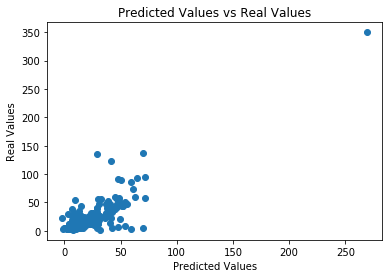

In [208]:
#a plot of 
import matplotlib.pyplot as plt
plt.scatter(y_pred, y_test)
plt.xlabel('Predicted Values')
plt.ylabel('Real Values')
plt.title('Predicted Values vs Real Values')

In [201]:
#predicting house prices for new data:
#first one: a 100 m^2 house with 1 parking and 2 bedrooms in Niyavaran, worthes 28.8 billions!
#second one:  a 120 m^2 house with 2 parking and 3 bedrooms in Saadatabad, worthes 26 billions!

x= np.array([[100, 1, 2, 0, 0, 0, 1, 0],[120, 2, 3 , 0, 1, 0, 0, 0]])

regression.predict(x)

array([28.81757105, 26.11142297])

# Remark:
It was better to only focus on a few places like 5 places to get more data for them. But, website did not let me to scrape again because of reaching maximum searches.